In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [1]:
from import_modules_stdm import *

with open('config_stdm.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

In [2]:
all_parameter_comb = ParameterGrid(cfg["hyper_par"])
print(len(all_parameter_comb))
filtered_params = list({key: value for key, value in cfg["hyper_par"].items() if len(value) > 1}.keys())

4


1 / 4 gridsearch step


Training Epochs: 100%|██████████| 50/50 [05:38<00:00,  6.77s/it, Train_loss=2.298e-02, Val_loss=1.272e-01]


Best epoch: 47


Predictions: 100%|██████████| 200/200 [00:02<00:00, 75.27it/s]


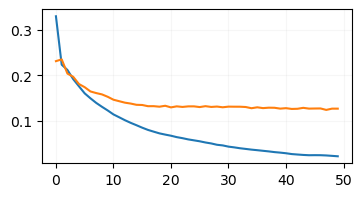

MSE = 6.40848e-01
NEW BEST!
Parameters: {
    dropout: 0
}


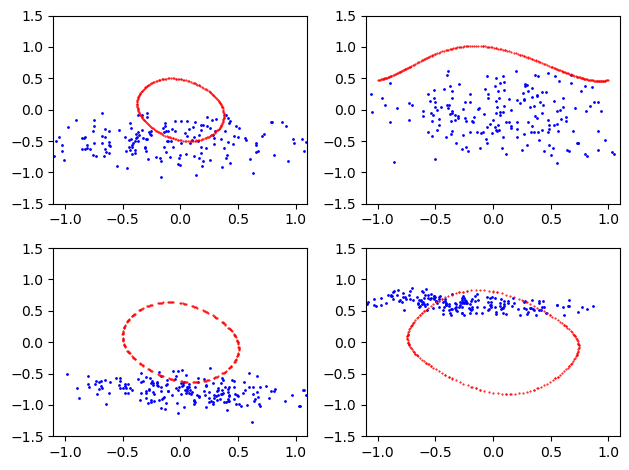

-------------------------------------------------------------
2 / 4 gridsearch step


Training Epochs: 100%|██████████| 50/50 [05:49<00:00,  6.99s/it, Train_loss=2.232e-02, Val_loss=1.140e-01]


Best epoch: 25


Predictions: 100%|██████████| 200/200 [00:02<00:00, 74.92it/s]


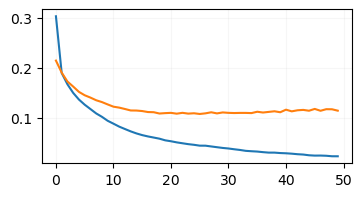

MSE = 6.15658e-01
NEW BEST!
Parameters: {
    dropout: 0.01
}


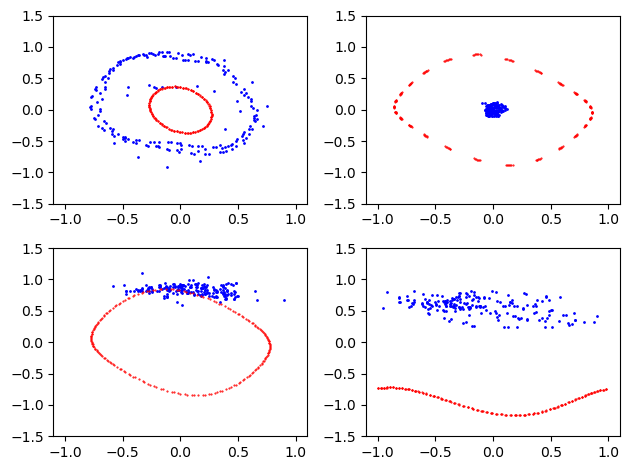

-------------------------------------------------------------
3 / 4 gridsearch step


Training Epochs: 100%|██████████| 50/50 [05:44<00:00,  6.90s/it, Train_loss=3.141e-02, Val_loss=1.081e-01]


Best epoch: 28


Predictions: 100%|██████████| 200/200 [00:03<00:00, 63.34it/s]


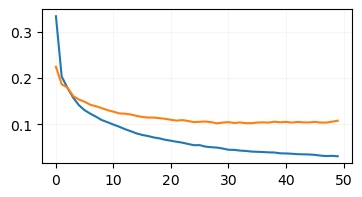

MSE = 6.19810e-01
Parameters: {
    dropout: 0.05
}


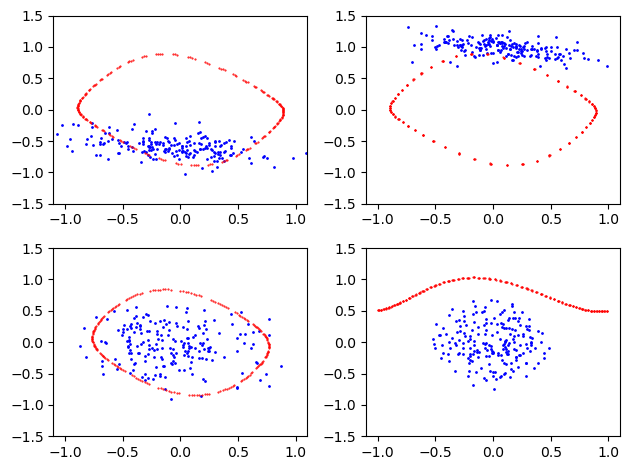

-------------------------------------------------------------
4 / 4 gridsearch step


Training Epochs: 100%|██████████| 50/50 [05:29<00:00,  6.59s/it, Train_loss=3.222e-02, Val_loss=8.532e-02]


Best epoch: 43


Predictions: 100%|██████████| 200/200 [00:02<00:00, 70.30it/s]


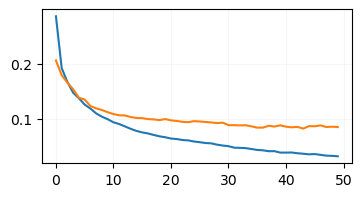

MSE = 5.76255e-01
NEW BEST!
Parameters: {
    dropout: 0.1
}


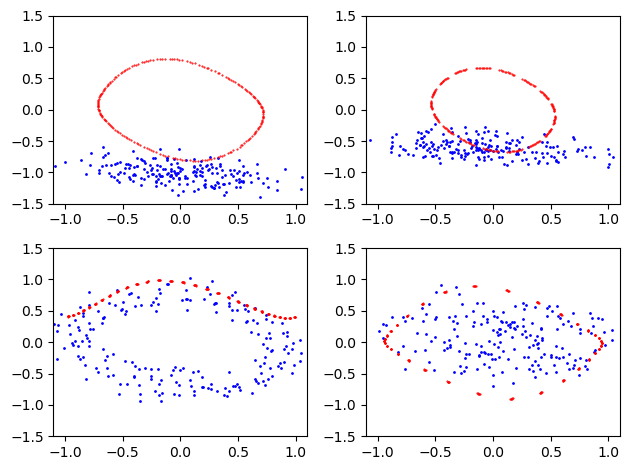

-------------------------------------------------------------


In [3]:
best_mse = np.inf
best_model = None

for iteration, params in enumerate(all_parameter_comb):

    print(f"{iteration + 1} / {len(all_parameter_comb)} gridsearch step")

    thetas, ps = standard_map(init_points=params["init_points"], steps=params["steps"], K=cfg["stdm"]["K"])
    thetas = ML.preprocess(thetas)

    ml_train = ML(window_size=params["window_size"], step_size=params["step_size"], train_size=cfg["model"]["train_size"], val_size=cfg["model"]["val_size"])

    X, y = ml_train.make_sequences(thetas, ps, sequences=params["sequences"])

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=cfg["model"]["val_size"], shuffle=params["shuffle"])

    X_train = torch.Tensor(np.array(X_train))
    X_val = torch.Tensor(np.array(X_val))
    y_train = torch.Tensor(np.array(y_train))
    y_val = torch.Tensor(np.array(y_val))

    model = Model(input_size=X_train.shape[-1], hidden_size=params["hidden_units"], dropout=params["dropout"], num_layers=params["num_layers"], model_type="RNN")

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)

    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params["learn_rate"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss, val_loss, model = ml_train.gradient_descent(model, params["epochs"], train_loader, optimizer, device, val_loader, train_dataset, val_dataset, criterion, verbose=1)

    thetas_test, ps_test = standard_map(init_points=params["init_points"], steps=params["steps"], K=cfg["stdm"]["K"])
    thetas_test = ML.preprocess(thetas_test)

    ml_test = ML(window_size=params["window_size"], step_size=params["step_size"], train_size=cfg["model"]["train_size"], val_size=cfg["model"]["val_size"])

    X_test, y_test = ml_test.make_sequences(thetas_test, ps_test, sequences=params["sequences"], predict=True)

    X_test = torch.Tensor(np.array(X_test))

    test_preds = ml_test.predictions(model=model, device=device, seed=X_test, num_predictions=y_test.shape[1], sequences=params["sequences"])

    plt.figure(figsize=(4, 2))
    plt.plot(train_loss, color='tab:blue')
    plt.plot(val_loss, color='tab:orange')
    plt.grid(alpha=0.1)
    plt.show()

    y_test = np.array(y_test)

    mse = np.mean(np.square(y_test - test_preds))
    print(f"MSE = {mse:.5e}")

    if mse < best_mse:
        best_mse = mse
        best_model = model
        print("NEW BEST!")

    print("Parameters: {")
    for key in filtered_params:
        print(f"    {key}: {params[key]}")
    print("}")

    if params["sequences"] == "linear":
        num_plots = test_preds.shape[0]
        num_rows = (num_plots + 1) // 2
        for k in range(num_plots):
            plt.subplot(num_rows, 2, k + 1)
            plt.plot(test_preds[k, :, 0], test_preds[k, :, 1], "bo", markersize=1)
            plt.plot(y_test[k, :, 0], y_test[k, :, 1], "ro", markersize=0.5)
            plt.plot(test_preds[k, 0, 0], test_preds[k, 0, 1], "bo", markersize=5)

            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.5, 1.5)
            plt.tight_layout()

    elif params["sequences"] == "parallel":
        for k in range(4):
            plt.subplot(2, 2, k + 1)
            plt.plot(test_preds[:, :, 2 * k], test_preds[:, :, 2 * k + 1], "bo", markersize=1)
            plt.plot(y_test[:, :, 2 * k], y_test[:, :, 2 * k + 1], "ro", markersize=0.5)

            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.5, 1.5)
            plt.tight_layout()

    plt.show()

    print("-------------------------------------------------------------")

    iteration += 1